## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.8]
redice_lr_patient = [2,5]

In [10]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0807 00:24:49.884208  4500 deprecation_wrapper.py:119] From C:\Users\Win7\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 00:24:49.887208  4500 deprecation_wrapper.py:119] From C:\Users\Win7\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 00:24:49.895209  4500 deprecation_wrapper.py:119] From C:\Users\Win7\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 00:24:50.027216  4500 deprecation_wrapper.py:119] From C:\Users\Win7\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 2


W0807 00:24:50.480242  4500 deprecation_wrapper.py:119] From C:\Users\Win7\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 00:24:50.495243  4500 deprecation_wrapper.py:119] From C:\Users\Win7\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0807 00:24:50.655252  4500 deprecation.py:323] From C:\Users\Win7\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 249us/step - loss: 2.2398 - acc: 0.2682 - val_loss: 2.1767 - val_acc: 0.3027
Epoch 2/10
50000/50000 [==============================] - 9s 190us/step - loss: 1.7518 - acc: 0.3904 - val_loss: 1.8048 - val_acc: 0.3770
Epoch 3/10
50000/50000 [==============================] - 9s 183us/step - loss: 1.6278 - acc: 0.4303 - val_loss: 1.6976 - val_acc: 0.4081
Epoch 4/10
50000/50000 [==============================] - 9s 182us/step - loss: 1.5523 - acc: 0.4574 - val_loss: 1.6328 - val_acc: 0.4259
Epoch 5/10
50000/50000 [==============================] - 8s 170us/step - loss: 1.4974 - acc: 0.4764 - val_loss: 1.6079 - val_acc: 0.4305
Epoch 6/10
50000/50000 [==============================] - 9s 175us/step - loss: 1.4509 - acc: 0.4896 - val_loss: 1.5625 - val_acc: 0.4532
Epoch 7/10
50000/50000 [==============================] - 9s 178us/step - loss: 1.4098 - acc: 0.5064 - val_loss: 1.5427 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 223us/step - loss: 2.2131 - acc: 0.2715 - val_loss: 2.1031 - val_acc: 0.3172
Epoch 2/10
50000/50000 [==============================] - 11s 227us/step - loss: 1.7434 - acc: 0.3894 - val_loss: 1.7917 - val_acc: 0.3803
Epoch 3/10
50000/50000 [==============================] - 11s 221us/step - loss: 1.6194 - acc: 0.4341 - val_loss: 1.7041 - val_acc: 0.4079
Epoch 4/10
50000/50000 [==============================] - 10s 202us/step - loss: 1.5501 - acc: 0.4577 - val_loss: 1.6433 - val_acc: 0.4232
Epoch 5/10
50000/50000 [==============================] - 11s 212us/step - loss: 1.4942 - acc: 0.4784 - val_loss: 1.5921 - val_acc: 0.4385
Epoch 6/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.4480 - acc: 0.4944 - val_loss: 1.5798 - val_acc: 0.4425
Epoch 7/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.4060 - acc: 0.5090 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 216us/step - loss: 1.7583 - acc: 0.3904 - val_loss: 1.8233 - val_acc: 0.3697
Epoch 2/10
50000/50000 [==============================] - 9s 190us/step - loss: 1.4809 - acc: 0.4802 - val_loss: 1.9832 - val_acc: 0.3423
Epoch 3/10
50000/50000 [==============================] - 10s 195us/step - loss: 1.3835 - acc: 0.5154 - val_loss: 1.7048 - val_acc: 0.3999
Epoch 4/10
50000/50000 [==============================] - 10s 196us/step - loss: 1.3090 - acc: 0.5410 - val_loss: 1.8038 - val_acc: 0.3800
Epoch 5/10
50000/50000 [==============================] - 9s 189us/step - loss: 1.2459 - acc: 0.5661 - val_loss: 1.5231 - val_acc: 0.4575
Epoch 6/10
50000/50000 [==============================] - 10s 197us/step - loss: 1.1912 - acc: 0.5841 - val_loss: 1.4948 - val_acc: 0.4675
Epoch 7/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.1394 - acc: 0.6056 - val_loss: 1.48

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 236us/step - loss: 1.8387 - acc: 0.3688 - val_loss: 2.2679 - val_acc: 0.3042
Epoch 2/10
50000/50000 [==============================] - 10s 201us/step - loss: 1.5513 - acc: 0.4595 - val_loss: 2.0742 - val_acc: 0.3100
Epoch 3/10
50000/50000 [==============================] - 10s 205us/step - loss: 1.4454 - acc: 0.4947 - val_loss: 1.9646 - val_acc: 0.3380
Epoch 4/10
50000/50000 [==============================] - 11s 214us/step - loss: 1.3640 - acc: 0.5221 - val_loss: 1.9083 - val_acc: 0.3520
Epoch 5/10
50000/50000 [==============================] - 9s 188us/step - loss: 1.3031 - acc: 0.5454 - val_loss: 1.9418 - val_acc: 0.3665
Epoch 6/10
50000/50000 [==============================] - 9s 179us/step - loss: 1.2553 - acc: 0.5647 - val_loss: 1.9988 - val_acc: 0.3416
Epoch 7/10
50000/50000 [==============================] - 9s 184us/step - loss: 1.2045 - acc: 0.5845 - val_loss: 2.126

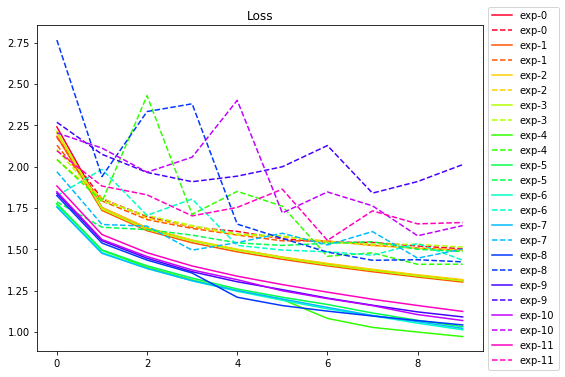

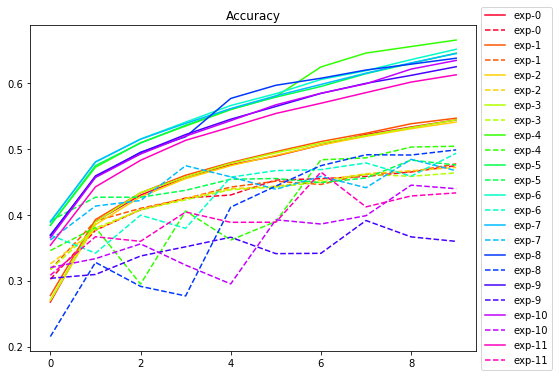

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()